### define

In [1]:
from resources.utils import *
from gensim.models import Word2Vec

!mkdir -p ./logs
!mkdir -p ./models

## create corpuses

Optional filter

In [10]:
spec_ids = [int(u['_id']) for u in tn(mc['github']['users'].find({'country_code': 'ua', 'type': 'USR'}, {}))]
len(spec_ids)

33984

In [10]:
spec_ids = [int(u['_id']) for u in tn(mc['github']['projects'].find({'language': 'Python'}, {}))]
len(spec_ids)

33984

In [10]:
spec_ids = [int(u['_id']) for u in tn(mc['github']['repos_watches_embeddings'].find({'n_vecs': {'$gte': 200}}, {}))]
len(spec_ids)

85625

In [11]:
corpus_filepath = './data/following_corpus.txt'
min_folls = 2
# max_folls = 5000

find = mc['github']['following'].find({'following_count': {'$gte': min_folls}}, ['following_ids'])
SG = SentencesGenerator()
SG.save((u['following_ids'] for u in find),
        corpus_filepath,
        min_words=min_folls,
#         max_words=max_folls,
#         interested_uids=spec_ids
       )

In [11]:
corpus_filepath = './data/followers_corpus.txt'
min_folls = 2
# max_folls = 5000

find = mc['github']['followers'].find({'followers_count': {'$gte': min_folls}}, ['followers_ids'])
SG = SentencesGenerator()
SG.save((u['followers_ids'] for u in find),
        corpus_filepath,
        min_words=min_folls,
#         max_words=max_folls,
#         interested_uids=spec_ids
       )

In [12]:
corpus_filepath = './data/users_watches_corpus_gte200.txt'
min_repos = 2
# max_repos = 5000

find = mc['github']['users_watches'].find({'repos_count': {'$gte': min_repos}}, ['repos_ids'])
SG = SentencesGenerator()
SG.save((u['repos_ids'] for u in find),
        corpus_filepath,
        min_words=min_repos,
#         max_words=max_repos,
        interested_uids=spec_ids
       )

Total words: 90808007


## train models

### skip-n-gram

#### following sg_d300_w30_mc3_e5

In [4]:
corpus_filepath = './data/following_corpus.txt'

In [5]:
model_name = 'users_following_emb_sg_d300_w30_mc3_e5'
set_logging('./logs/' + model_name + '.log')
# model = Word2Vec.load('./models/' + model_name + '.bin')
# print(model)

In [6]:
model = Word2Vec(size=300, window=30, min_count=3, sg=1, workers=8, compute_loss=True, seed=4, negative=5, iter=5)
model.build_vocab(corpus_file=corpus_filepath, progress_per=10000)
print(model)

Word2Vec(vocab=1385758, size=300, alpha=0.025)


In [7]:
a = [w.count for w in model.wv.vocab.values()]
corpus, unique_words, total_words = model.corpus_count, len(a), model.corpus_total_words
msg = f'model (corpus={corpus}, unique_words={unique_words}, total_words={total_words})'
# tgn(msg)
msg

'model (corpus=2140201, unique_words=1385758, total_words=28115972)'

In [8]:
len([c for c in a if c >= 5])

869232

In [9]:
len([c for c in a if c >= 10])

437505

3     1385758
4     1071383
5      869232
6      728056
7      626401
8      548479
9      487234
10     437505
11     396163
12     361544
13     331820
14     306339
15     284352
16     264735
17     247389
18     232038
19     218086
20     205319
dtype: int64


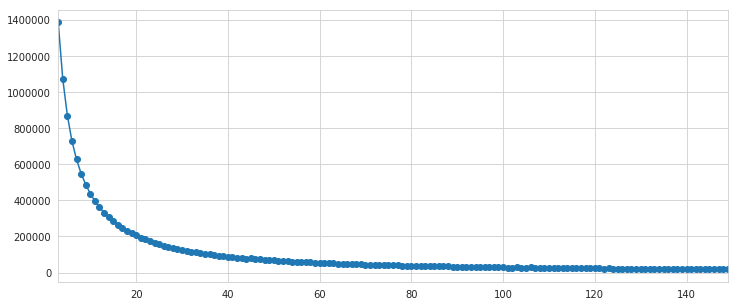

In [10]:
s = pd.Series(a).value_counts().sort_values().cumsum()
s = s[s.index < 150].dropna().sort_values(ascending=False)
print(s[:18])
s.plot(marker='o');

150    17950
167    17651
156    17505
155    17359
158    17068
154    16926
157    16790
151    16658
163    16526
164    16395
153    16266
166    16138
152    16013
165    15889
162    15770
171    15652
174    15537
173    15422
dtype: int64


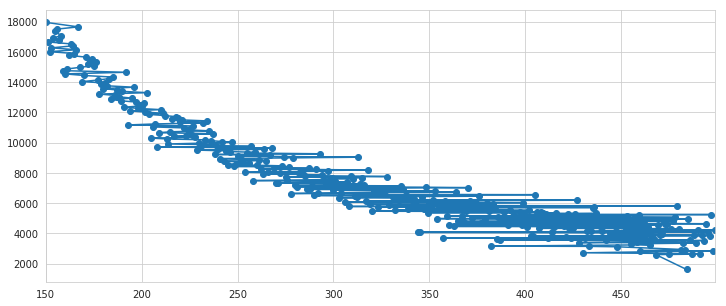

In [11]:
s = pd.Series(a).value_counts().sort_values().cumsum()
s = s[(s.index >= 150) & (s.index < 500)].dropna().sort_values(ascending=False)
print(s[:18])
s.plot(marker='o');

In [12]:
try:
    good, total = model.train(corpus_file=corpus_filepath, epochs=model.epochs, total_examples=model.corpus_count, total_words=model.corpus_total_words)
    model.save('./models/' + model_name + '.bin')
    msg = f'[model] iters pairs (good?={good}, total={total})'
except Exception as e:
    msg = f'[model] error - {e}'
tgn(msg)
msg

'model iters pairs (good?=120174072, total=140103830)'

#### followers sg_d300_w30_mc3_e5

In [ ]:
corpus_filepath = './data/followers_corpus.txt'

In [2]:
model_name = 'users_followers_emb_sg_d300_w30_mc3_e5'
set_logging('./logs/' + model_name + '.log')
# model = Word2Vec.load('./models/' + model_name + '.bin')
# print(model)

In [4]:
model = Word2Vec(size=300, window=30, min_count=3, sg=1, workers=8, compute_loss=True, seed=4, negative=5, iter=5)
model.build_vocab(corpus_file=corpus_filepath, progress_per=10000)
print(model)

Word2Vec(vocab=1446832, size=300, alpha=0.025)


In [5]:
a = [w.count for w in model.wv.vocab.values()]
corpus, unique_words, total_words = model.corpus_count, len(a), model.corpus_total_words
msg = f'model (corpus={corpus}, unique_words={unique_words}, total_words={total_words})'
# tgn(msg)
msg

'model (corpus=2106067, unique_words=1446832, total_words=28122605)'

In [6]:
len([c for c in a if c >= 5])

945502

In [7]:
len([c for c in a if c >= 10])

496043

3     1446832
4     1143242
5      945502
6      804281
7      698275
8      616540
9      550609
10     496043
11     450228
12     411470
13     378455
14     349943
15     324625
16     302088
17     282382
18     264765
19     248715
20     234213
dtype: int64


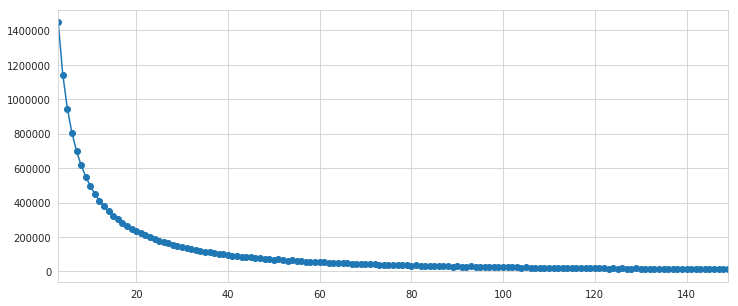

In [8]:
s = pd.Series(a).value_counts().sort_values().cumsum()
s = s[s.index < 150].dropna().sort_values(ascending=False)
print(s[:18])
s.plot(marker='o');

150    13085
153    12940
154    12796
151    12657
157    12519
155    12382
158    12250
152    11859
160    11733
162    11608
156    11488
167    11253
159    11137
164    11022
163    10909
175    10800
171    10696
161    10592
dtype: int64


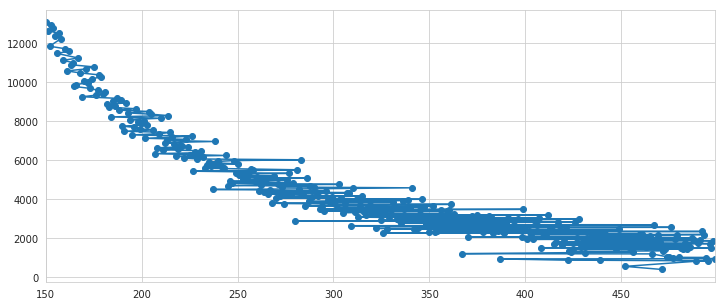

In [9]:
s = pd.Series(a).value_counts().sort_values().cumsum()
s = s[(s.index >= 150) & (s.index < 500)].dropna().sort_values(ascending=False)
print(s[:18])
s.plot(marker='o');

In [11]:
try:
    good, total = model.train(corpus_file=corpus_filepath, epochs=model.epochs, total_examples=model.corpus_count, total_words=model.corpus_total_words)
    model.save('./models/' + model_name + '.bin')
    msg = f'[model] iters pairs (good?={good}, total={total})'
except Exception as e:
    msg = f'[model] error - {e}'
tgn(msg)
msg

'model iters pairs (good?=24268337, total=28122605)'

#### users_watches sg_d300_w30_mc3_e5

In [6]:
corpus_filepath = './data/users_watches_corpus.txt'

In [5]:
model_name = 'repos_watches_emb_sg_d300_w30_mc3_e5'
set_logging('./logs/' + model_name + '.log')
# model = Word2Vec.load('./models/' + model_name + '.bin')
# print(model)

In [7]:
model = Word2Vec(size=300, window=30, min_count=3, sg=1, workers=8, compute_loss=True, seed=4, negative=5, iter=5)
model.build_vocab(corpus_file=corpus_filepath, progress_per=10000)
print(model)

Word2Vec(vocab=2371786, size=300, alpha=0.025)


In [8]:
a = [w.count for w in model.wv.vocab.values()]
corpus, unique_words, total_words = model.corpus_count, len(a), model.corpus_total_words
msg = f'model (corpus={corpus}, unique_words={unique_words}, total_words={total_words})'
# tgn(msg)
msg

'model (corpus=3617623, unique_words=2371786, total_words=136354835)'

In [9]:
len([c for c in a if c >= 5])

1527750

In [10]:
len([c for c in a if c >= 10])

889389

In [11]:
len([c for c in a if c >= 100])

153445

3     2371786
4     1838883
5     1527750
6     1319338
7     1168458
8     1054191
9      963214
10     889389
11     827550
12     775401
13     730715
14     691670
15     657144
16     626259
17     598630
18     573711
19     551316
20     530637
dtype: int64


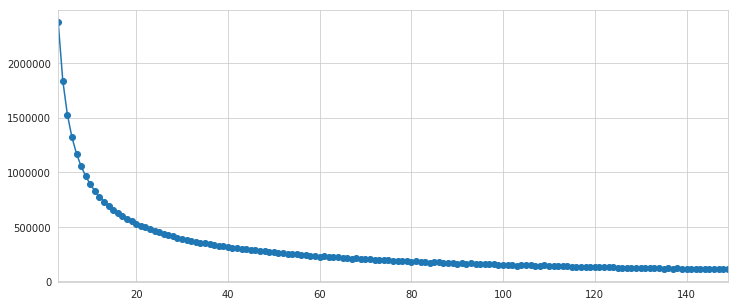

In [12]:
s = pd.Series(a).value_counts().sort_values().cumsum()
s = s[s.index < 150].dropna().sort_values(ascending=False)
print(s[:18])
s.plot(marker='o');

155    109506
151    108884
152    108265
153    107668
161    107076
156    106489
150    105904
154    105321
158    104742
165    104188
162    103640
159    103093
157    102546
160    102000
164    101466
172    100933
168    100405
163     99881
dtype: int64


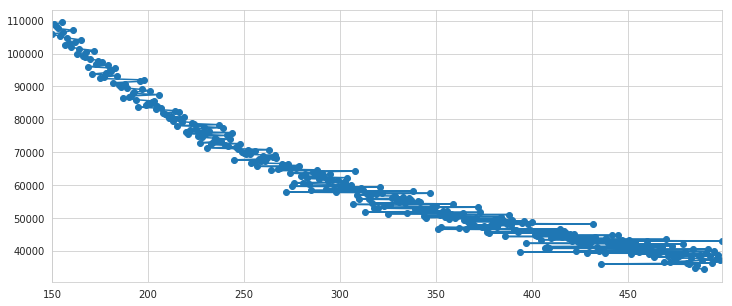

In [13]:
s = pd.Series(a).value_counts().sort_values().cumsum()
s = s[(s.index >= 150) & (s.index < 500)].dropna().sort_values(ascending=False)
print(s[:18])
s.plot(marker='o');

In [14]:
try:
    good, total = model.train(corpus_file=corpus_filepath, epochs=model.epochs, total_examples=model.corpus_count, total_words=model.corpus_total_words)
    model.save('./models/' + model_name + '.bin')
    msg = f'[model] iters pairs (good?={good}, total={total})'
except Exception as e:
    msg = f'[model] error - {e}'
tgn(msg)
msg

'model iters pairs (good?=631578110, total=681478615)'

#### users_watches sg_d300_w50_mc200_e50

In [4]:
corpus_filepath = './data/users_watches_corpus_gte200.txt'

In [5]:
model_name = 'repos_watches_emb_sg_d300_w50_mc200_e50'
set_logging('./logs/' + model_name + '.log')
# model = Word2Vec.load('./models/' + model_name + '.bin')
# print(model)

In [6]:
model = Word2Vec(size=300, window=50, min_count=200, sg=1, workers=8, compute_loss=True, seed=4, negative=5, iter=50)
model.build_vocab(corpus_file=corpus_filepath, progress_per=10000)
print(model)

Word2Vec(vocab=84973, size=300, alpha=0.025)


In [7]:
a = [w.count for w in model.wv.vocab.values()]
corpus, unique_words, total_words = model.corpus_count, len(a), model.corpus_total_words
msg = f'model (corpus={corpus}, unique_words={unique_words}, total_words={total_words})'
# tgn(msg)
msg

'model (corpus=2596563, unique_words=84973, total_words=90808007)'

In [8]:
len([c for c in a if c >= 500])

36902

200    84973
201    84573
204    84175
205    83796
202    83432
203    83071
212    82712
214    82354
207    82002
217    81653
206    81305
211    80962
209    80628
219    80297
208    79969
210    79650
216    79332
229    79018
dtype: int64


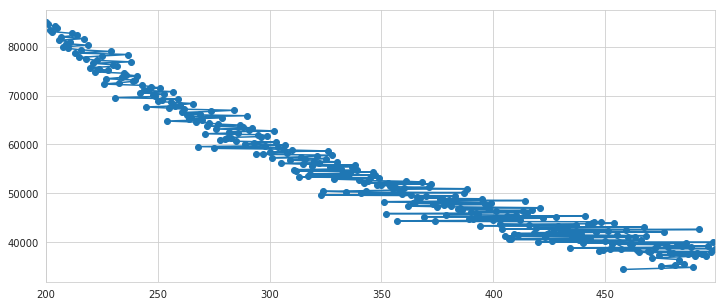

In [9]:
s = pd.Series(a).value_counts().sort_values().cumsum()
s = s[(s.index >= 200) & (s.index < 500)].dropna().sort_values(ascending=False)
print(s[:18])
s.plot(marker='o');

505    38920
507    38454
501    37402
508    37188
502    37049
510    36980
559    36911
594    36843
596    36707
597    36639
512    36571
517    36503
522    36368
513    36302
504    36236
519    36170
509    36104
547    36039
dtype: int64


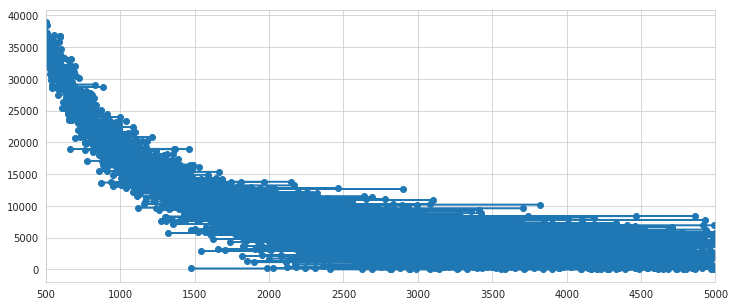

In [ ]:
s = pd.Series(a).value_counts().sort_values().cumsum()
s = s[(s.index >= 500) & (s.index < 5000)].dropna().sort_values(ascending=False)
print(s[:18])
s.plot(marker='o');

In [ ]:
try:
    good, total = model.train(corpus_file=corpus_filepath, epochs=model.epochs, total_examples=model.corpus_count, total_words=model.corpus_total_words)
    model.save('./models/' + model_name + '.bin')
    msg = f'[model] iters pairs (good?={good}, total={total})'
except Exception as e:
    msg = f'[model] error - {e}'
tgn(msg)
msg

## save

### following

In [14]:
uids = list(model.wv.vocab.keys())
len(uids)

1385758

In [15]:
col_name = 'users_following_embeddings'

In [16]:
mc['github'][col_name].create_index('n_vecs')

'n_vecs_1'

In [17]:
chunk = []

for uid in tn(uids):
    chunk.append({
        '_id': int(uid),
        'n_vecs': model.wv.vocab.get(uid).count,
        'vec': model.wv[uid].tolist()
    })
    if len(chunk) >= 10_000:
        mc['github'][col_name].insert_many(chunk)
        chunk = []
if len(chunk):
    mc['github'][col_name].insert_many(chunk)
mc['github'][col_name].estimated_document_count()

1385758

### repos_stars

In [ ]:
rids = list(model.wv.vocab.keys())
len(rids)

In [ ]:
col_name = 'repos_stars_embeddings'

In [ ]:
mc['github'][col_name].create_index('n_vecs')

In [ ]:
chunk = []

for rid in tn(rids):
    chunk.append({
        '_id': int(rid),
        'n_vecs': model.wv.vocab.get(rid).count,
        'vec': model.wv[rid].tolist()
    })
    if len(chunk) >= 10_000:
        mc['github'][col_name].insert_many(chunk)
        chunk = []
if len(chunk):
    mc['github'][col_name].insert_many(chunk)
mc['github'][col_name].estimated_document_count()